<a href="https://colab.research.google.com/github/kpr-03/DeepLearning_TensorFlow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.8.0
import tensorflow as tf
print(tf.__version__)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 44.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 30.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.1
    Uninstalling tensorboard-data-server-0.7.1:
      Successfully uninstalled tensorboard-data-server-0.7.1
  Attempting uninstall: google-auth-oauthlib
    Found existing insta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Transfer learning with Tensorflow part 3: Scaling up(Food vision mini)
We've seen power of transfer learning feature extration and fine tunining,now it's time to scale up to all of the classes in Food101 (101 total classes of food).

Our goal is to beat the original Food101 paper with 10% of the training(leveraging the power of deep learning).

Original Food101 paper:chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

Our baseline is to beat 50.76% accuracy across 101 classes.

In [ ]:
# check to see if we're using GPU
!nvidia-smi

Sun Sep 10 06:45:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/kpr-03/DeepLearning_TensorFlow/main/extras/helper_functions.py

--2023-09-10 06:45:24--  https://raw.githubusercontent.com/kpr-03/DeepLearning_TensorFlow/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-10 06:45:25 (80.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback,plot_loss_curves,unzip_data,compare_historys,walk_through_dir

## 101 Food classes:working with less data
Our goal is to beat original Food101 paper with 10% of the training data,so let's download it.

The data we're downloading comes from the original Food101 dataset
but has been preprocessed using the image_data_notification motebook : https://raw.githubusercontent.com/kpr-03/DeepLearning_TensorFlow/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-09-10 06:45:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 74.125.68.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  18.4MB/s    in 91s     

2023-09-10 06:46:57 (17.1 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_bolognese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beignets'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/caprese_salad'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pad_thai'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/french_onion_soup'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bibimbap'.
There are 0 directories and 75 images in '

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 Food classes

Here are the steps we're going to take:
* Create ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right  into the model.
* Build a headless (no top layers)Functional EfficientNetB0 backboned model(we'll create our own output layer).
* Compile our model.
* Feature extract for 5 full classes( 5 epochs on the train dataset and validate on 15% of the test data,to save epoch time).

In [ ]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## OLD
# # Setup data augmentation
# from tensorflow.keras.layers.experimental import preprocessing
# data_augmentation = Sequential([
#   preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
#   preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
#   preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
#   preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
#   preprocessing.RandomZoom(0.2), # randomly zoom into an image
#   # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16719872/16705208 [==============================] - 2s 0us/step


In [ ]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 112s 410ms/step - loss: 3.4652 - accuracy: 0.2446 - val_loss: 2.5601 - val_accuracy: 0.4378
Epoch 2/5
237/237 [==============================] - 67s 278ms/step - loss: 2.3496 - accuracy: 0.4566 - val_loss: 2.1736 - val_accuracy: 0.4703
Epoch 3/5
237/237 [==============================] - 53s 223ms/step - loss: 1.9766 - accuracy: 0.5295 - val_loss: 2.0390 - val_accuracy: 0.4881
Epoch 4/5
237/237 [==============================] - 57s 238ms/step - loss: 1.7626 - accuracy: 0.5731 - val_loss: 1.9725 - val_accuracy: 0.4897
Epoch 5/5
237/237 [==============================] - 50s 207ms/step - loss: 1.5945 - accuracy: 0.6049 - val_loss: 1.8963 - val_accuracy: 0.5037


In [ ]:
# Evaluate on the whole test data
fine_tuning_results=model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 91s 115ms/step - loss: 1.7124 - accuracy: 0.5503


[1.712350845336914, 0.5502574443817139]

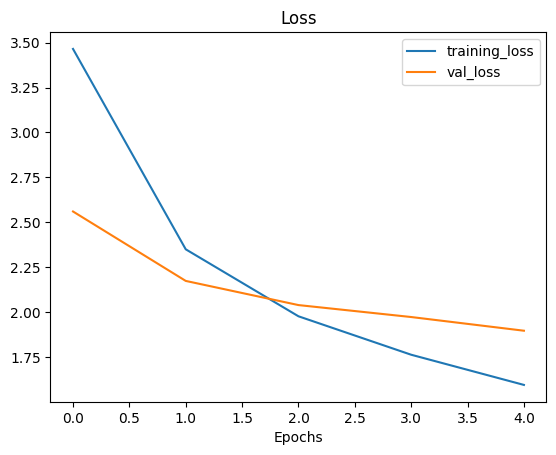

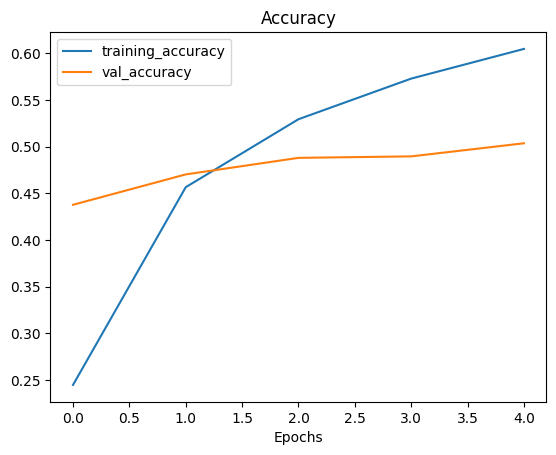

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

>:? **Question:** What do these curves suggest? Hint:Ideally,the two curves should be very similar to each other,if not it may suggest that our model is overfitting(performing too well on the training data and not genralizing to unseen data).


## Fine-tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable=True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [ ]:
# Recompile model with lower learning(it's typically best practice to lower the learning rate when fine tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#learning rate lowered by 10x
              metrics=["accuracy"])

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number,layer in enumerate(model.layers[2].layers):
  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
#Fine-tune for 5 more epochs
fine_tune_epochs= 10 # model has lareadsy done 5 epochs(feature extraction),this is the total number of epochs we're after(5+5=10)

#Fine-tune our model
history_all_classes_10_percent_fine_tune= model.fit(train_data_all_10_percent,
                                                    epochs=fine_tune_epochs,
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 75s 267ms/step - loss: 1.3636 - accuracy: 0.6504 - val_loss: 1.9212 - val_accuracy: 0.4952
Epoch 6/10
237/237 [==============================] - 43s 181ms/step - loss: 1.2387 - accuracy: 0.6721 - val_loss: 1.9145 - val_accuracy: 0.5000
Epoch 7/10
237/237 [==============================] - 47s 196ms/step - loss: 1.1563 - accuracy: 0.6910 - val_loss: 1.9172 - val_accuracy: 0.5029
Epoch 8/10
237/237 [==============================] - 47s 198ms/step - loss: 1.0901 - accuracy: 0.7138 - val_loss: 1.8928 - val_accuracy: 0.5050
Epoch 9/10
237/237 [==============================] - 60s 250ms/step - loss: 1.0104 - accuracy: 0.7327 - val_loss: 1.9057 - val_accuracy: 0.5077
Epoch 10/10
237/237 [==============================] - 60s 251ms/step - loss: 0.9652 - accuracy: 0.7426 - val_loss: 1.8859 - val_accuracy: 0.5111


In [ ]:
# Evaluate on the whole test data
feature_extraction_results=model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 103s 130ms/step - loss: 1.6107 - accuracy: 0.5750


[1.6106573343276978, 0.5749703049659729]

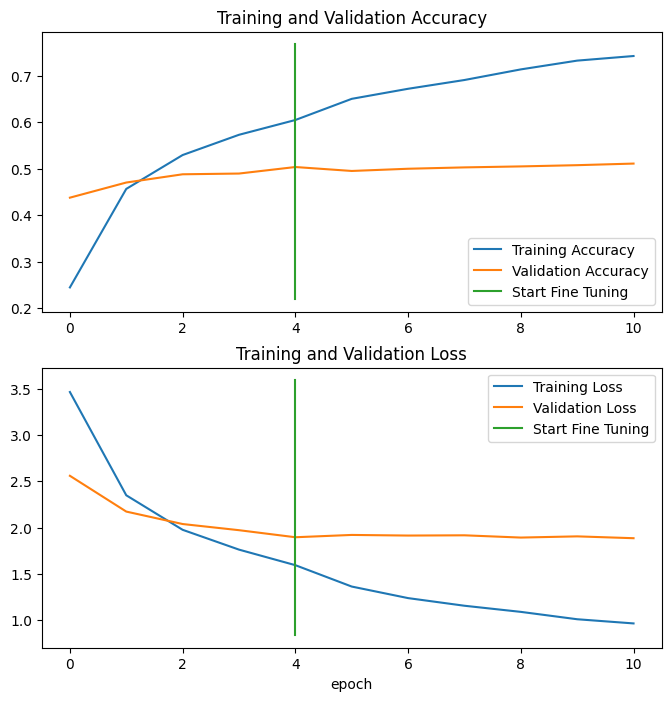

In [ ]:
# compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

# Saving and loading our model
To use our model in an external application,we'll need to save it and export it somewhere.

In [ ]:
# save our fine-tuning model
model.save("/drive/MyDrive/saved_model_tensorflow/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# load an evaluate saved model
loaded_model=tf.keras.models.load_model("/drive/MyDrive/saved_model_tensorflow/101_food_classes_10_percent_saved_big_dog_model")

In [ ]:
# Evalaute loaded model and compare performance to pre-saved model
loaded_model_results=loaded_model.evaluate(test_data)
loaded_model_results

790/790 [==============================] - 66s 81ms/step - loss: 1.6107 - accuracy: 0.5750


[1.6106573343276978, 0.5749703049659729]

In [ ]:
# The results from our loaded model(above) should be very similar to the results below
feature_extraction_results

[1.6106573343276978, 0.5749703049659729]

## Evaluating the performance of the big dog model across all different classes.

Let's make some predictions,visualize them and then later find out which predictions were the "most" wrong.

In [ ]:
import tensorflow as tf
# Download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2023-09-10 07:05:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  10.4MB/s    in 4.5s    

2023-09-10 07:06:03 (9.97 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
#Loading saved model
model =tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")

In [ ]:
# Evaluate loaded model
results_downloaded_model=model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 74s 92ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

## Making predictions with our trained model

In [ ]:
# Make predictions with model
preds_probs= model.predict(test_data,verbose=1) # Set verbosity to see how long is left

790/790 [==============================] - 70s 87ms/step


In [ ]:
len(test_data)

790

In [ ]:
# How many predictions are there?
len(preds_probs)

25250

In [ ]:
# What's the shape of iour predictions?
preds_probs.shape

(25250, 101)

In [ ]:
# Let's see what the fiorst ten predictions look like
preds_probs[:10]

array([[5.9542250e-02, 3.5742164e-06, 4.1377187e-02, ..., 1.4138726e-09,
        8.3530780e-05, 3.0897551e-03],
       [9.6401691e-01, 1.3753301e-09, 8.4780622e-04, ..., 5.4286953e-05,
        7.8362074e-12, 9.8466224e-10],
       [9.5925868e-01, 3.2533739e-05, 1.4866976e-03, ..., 7.1891338e-07,
        5.4397526e-07, 4.0275998e-05],
       ...,
       [4.7313249e-01, 1.2931206e-07, 1.4805575e-03, ..., 5.9749855e-04,
        6.6969078e-05, 2.3469336e-05],
       [4.4571787e-02, 4.7265317e-07, 1.2258493e-01, ..., 6.3498283e-06,
        7.5318690e-06, 3.6778722e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [ ]:
# What does first prediction probability look like
preds_probs[0],len(preds_probs[0]),sum(preds_probs[0])

(array([5.95422499e-02, 3.57421641e-06, 4.13771868e-02, 1.06605680e-09,
        8.16142265e-09, 8.66399219e-09, 8.09274582e-07, 8.56526867e-07,
        1.98591733e-05, 8.09777873e-07, 3.17277227e-09, 9.86742407e-07,
        2.85322807e-04, 7.80494447e-10, 7.42302567e-04, 3.89163870e-05,
        6.47404477e-06, 2.49773825e-06, 3.78912555e-05, 2.06783156e-07,
        1.55384569e-05, 8.15072838e-07, 2.62307503e-06, 2.00107493e-07,
        8.38279675e-07, 5.42160024e-06, 3.73910780e-06, 1.31505740e-08,
        2.77615967e-03, 2.80519544e-05, 6.85622448e-10, 2.55749364e-05,
        1.66889979e-04, 7.64073860e-10, 4.04531223e-04, 1.31507001e-08,
        1.79573817e-06, 1.44482760e-06, 2.30628420e-02, 8.24669542e-07,
        8.53656331e-07, 1.71387171e-06, 7.05256616e-06, 1.84021545e-08,
        2.85534099e-07, 7.94837069e-06, 2.06816003e-06, 1.85251395e-07,
        3.36199406e-08, 3.15226236e-04, 1.04109558e-05, 8.54483915e-07,
        8.47418129e-01, 1.05554591e-05, 4.40948469e-07, 3.740419

Our model outputs a prediction probability array(with N number of vartiables,where N is the number of classes) for each sample passes to the predict method.

In [ ]:
# We get one prediction probability per class ( in our case there's 101 prediction probability)
print(f"Number of prediction probabilities for sample 0:{len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with highest predicted probability by the model for sample 0:{preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0:101
What prediction probability sample 0 looks like:
 [5.95422499e-02 3.57421641e-06 4.13771868e-02 1.06605680e-09
 8.16142265e-09 8.66399219e-09 8.09274582e-07 8.56526867e-07
 1.98591733e-05 8.09777873e-07 3.17277227e-09 9.86742407e-07
 2.85322807e-04 7.80494447e-10 7.42302567e-04 3.89163870e-05
 6.47404477e-06 2.49773825e-06 3.78912555e-05 2.06783156e-07
 1.55384569e-05 8.15072838e-07 2.62307503e-06 2.00107493e-07
 8.38279675e-07 5.42160024e-06 3.73910780e-06 1.31505740e-08
 2.77615967e-03 2.80519544e-05 6.85622448e-10 2.55749364e-05
 1.66889979e-04 7.64073860e-10 4.04531223e-04 1.31507001e-08
 1.79573817e-06 1.44482760e-06 2.30628420e-02 8.24669542e-07
 8.53656331e-07 1.71387171e-06 7.05256616e-06 1.84021545e-08
 2.85534099e-07 7.94837069e-06 2.06816003e-06 1.85251395e-07
 3.36199406e-08 3.15226236e-04 1.04109558e-05 8.54483915e-07
 8.47418129e-01 1.05554591e-05 4.40948469e-07 3.74041920e-05
 3.53062715e-05 3.24890498e-05 6.73150862e-0

In [ ]:
# get the pred classes of each mnodel
pred_classes = preds_probs.argmax(axis=1)

#How do they look?
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [ ]:
# How many pred classes dow we have?
len(pred_classes)

25250

Now we've got a predictions array of all of our model's predictions,to evaluate them,we need to compare them to thw original test dataset labels.

In [ ]:
# to get our test labels we need to unravel our test_data BatchDataset
y_labels=[]
for images,labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# How many y_labels are there?
len(y_labels)

25250

## Evaluating our model's predictions

One way to check that our model's predictions array in the same order as our test labels array is to find the accuracy score


In [ ]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [ ]:
# let's try scikit-learn's accuracy score function and see what it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

In [ ]:
# Does this metrics come close to mour model's evaluate results
import numpy as np
np.isclose(results_downloaded_model[1],sklearn_accuracy)

True

## let's get visual:making a confusion matrix

In [ ]:
from helper_functions import make_confusion_matrix

In [ ]:
class_names=test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

### changed (plot x-labels vertically)###
  plt.xticks(rotation=70,fontsize=text_size)
  plt.yticks(fontsize=text_size)




  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      savefig=True)

### let'sd keep the evaluatoin train going,time for classification report

Scikit-learn has a helpful function for acquiring many differentclassification metrics per class(e.g precision,recall,F1) called
classification_report: https://colab.research.google.com/drive/19pk-gXiPWXkqB7U8WUlTTEwAFrWOemWO#scrollTo=5MUoA-FkI7jh&line=4&uniqifier=1. lets try it out.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

The numbers above give  agreat class-by-class evaluation of our model's predictions but with so many classes they are quite hard to understand.

How about we create a visualization to get better understanding?

In [ ]:
#Get a dictionary of classification report
classification_report_dict =classification_report(y_labels,pred_classes,output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

Let's plOt all of our classes F1-SCORES...

In [ ]:
# CREATE EMPTY DICTIONARY
class_f1_score={}
# Loop throughclassification report dictionary items
for k,v in classification_report_dict.items():
  if k == "accuracy":# stop once we get accuracy key
    break
  else:
    # Add class names and f1-score   to new dictionary
    class_f1_score[class_names[int(k)]]=v["f1-score"]
class_f1_score

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
# Turn f1-scores into dataframe for visualization
import pandas as pd
f1_scores=pd.DataFrame({"class_names":list(class_f1_score.keys()),
                        "f1-score":list(class_f1_score.values())}).sort_values("f1-score",ascending=False)

In [ ]:
# What does our dataframe does look like?
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

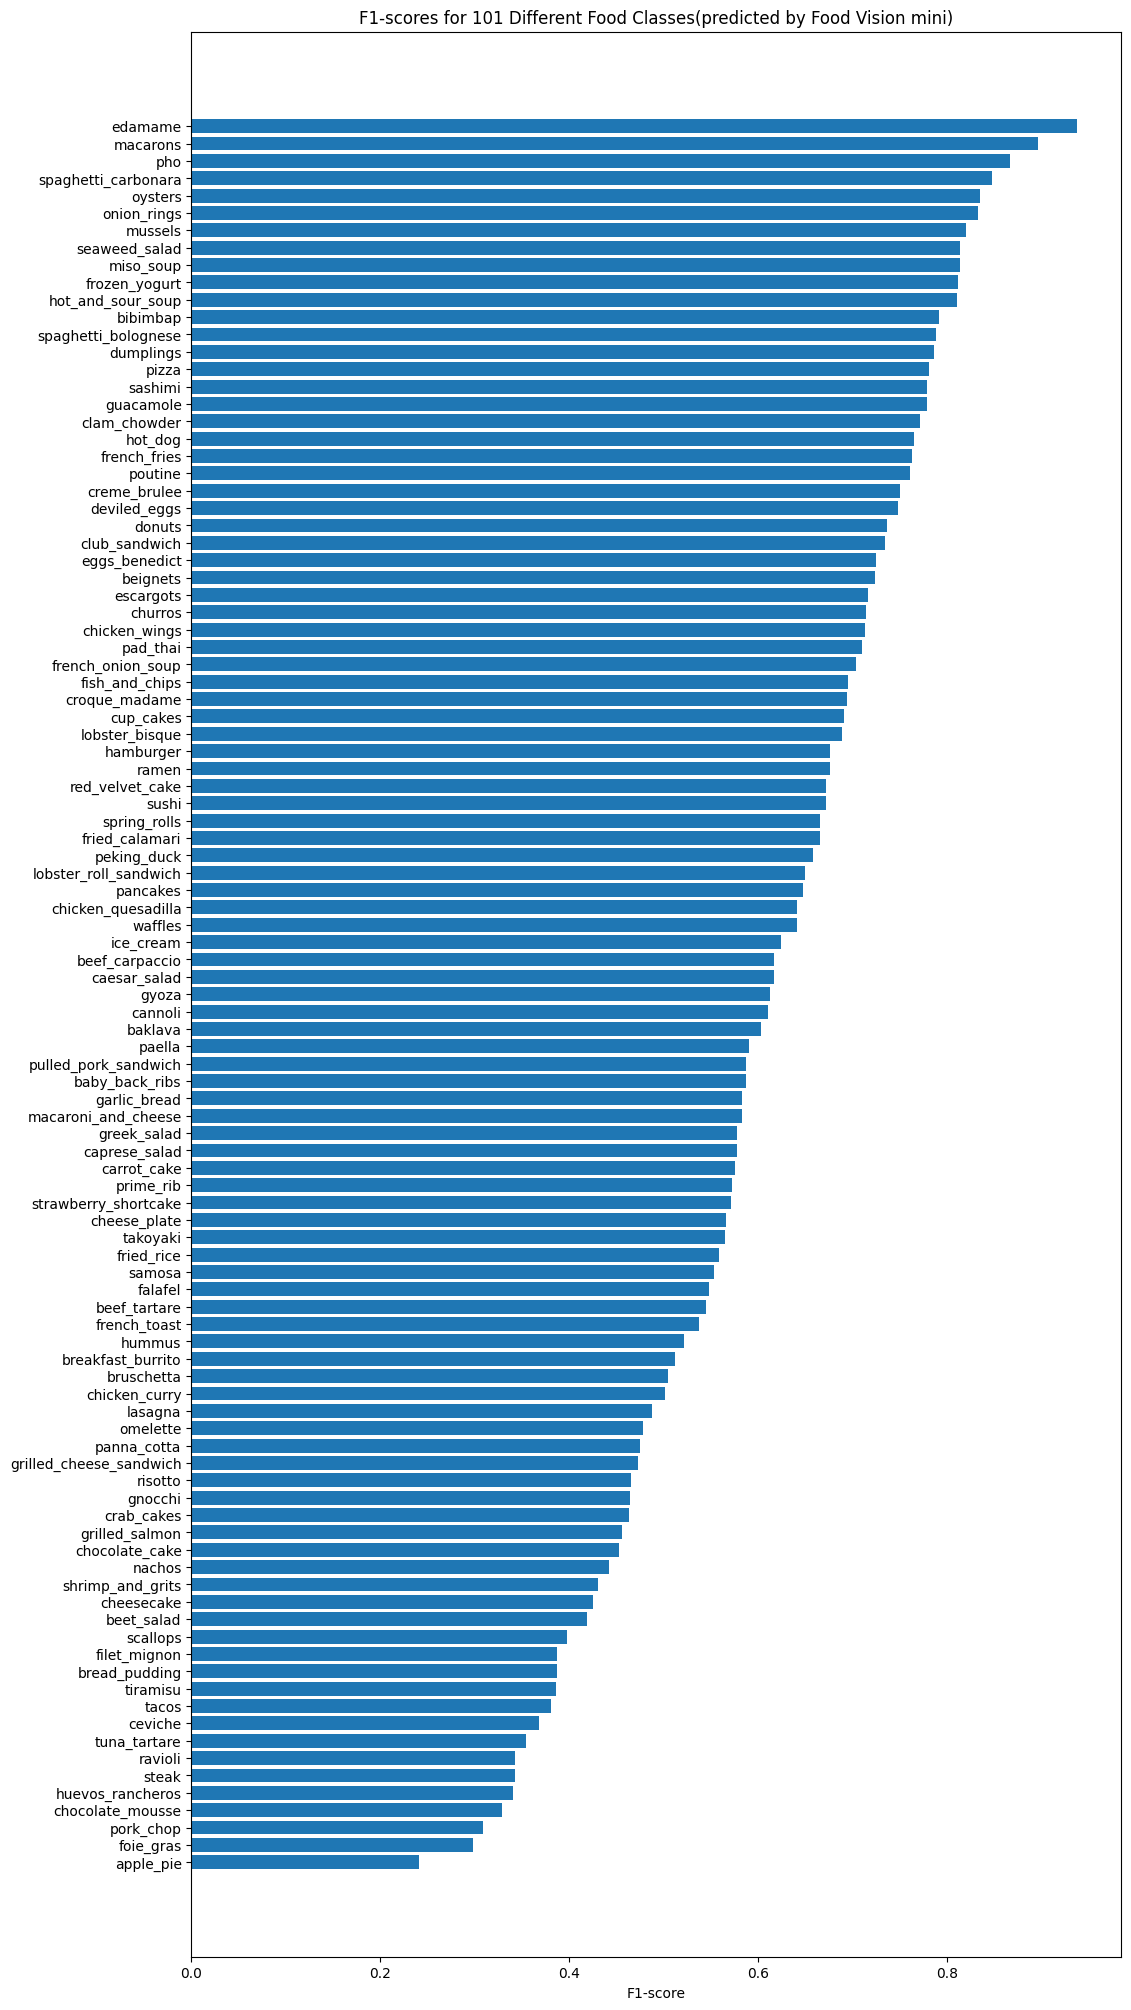

In [ ]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(figsize=(12,25))

scores = ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values) # get f1-score values

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes(predicted by Food Vision mini)")
ax.invert_yaxis(); # reverses the order of our plot

# add values to the end of each bar of what actual f1-score is
#(link:https://matplotlib.org/stable/gallery/statistics/barchart_demo.html)



In [ ]:
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

Let's try to visualize some of the most poorly predicted classes(e.g. apple_pie,pork_chip),and try to find  any trend among them? Why might our model be having trouble with them?


## Visualizing predictions on custom images
Now,this is the real test,how does our model go on food images not even in our test dataset(images of our own).

To Visiualize our model's predictions on our own images,we'll need a function to load and preprocess images,specifically it will need to:
* Read in a target image file path using tf.io.read_file()
*Turn the image into Tensor using tf.io.decode_images()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image_resize().
* Scale the nimages to get all of the pixel values between 0 & 1(if necessary)


In [ ]:
# create a function to load and prepare images
def load_and_prep_image(filename,img_shape=224,scale=True):
  """
  Reads in an image from file name,turns it into a tensor and reshapes it into specific shape
  (img_shape,img_shape,color_channels=3)

  Args:
   filename(str):path to target image
   image_shape(int):height/width dimension of target image size
   scale(bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    image tensor of shape(img_shape,img_shape,3)
  """
  # Read in the image
  img= tf.io.read_file(filename)

  # Decode image to tensor
  img=tf.io.decode_image(img,channels=3)

  # Resize the image
  img =  tf.image.resize(img,[img_shape,img_shape])

  # Scale? yes/no
  if scale:
    # rescale ther image (get all values between 0 and 1)
    return img/255.
  else:
    return img # Don't need to rescale images for EfficientNet models in TensorFlow

Now we've got a functio0n to load and prepare tarhget images,let's now write soje code to visualize images,tgheir target label and our model;'s predictions.

Specifically,we'll write some code to:
1. Load a few random images from the test datset.
2. Make predictions on loaded dataset.
3. plot the origina; images(s) along with the model's predictions,prediction probability and truth label.

[[6.69508893e-11 2.42780848e-11 1.87935171e-12 5.33965017e-16
  1.10360200e-10 6.58491926e-15 7.03540738e-15 8.77117572e-17
  2.85562547e-15 1.26111090e-13 1.84979874e-12 1.43641440e-14
  5.21895374e-12 1.11225590e-13 8.14722638e-13 3.21411430e-12
  2.69031641e-09 1.69344709e-13 9.88578116e-14 6.12683723e-11
  1.66746306e-09 2.76255906e-13 2.44438343e-14 6.01201151e-08
  1.64589710e-13 1.54368990e-06 6.17387521e-12 2.78991430e-13
  3.84149743e-12 3.04896032e-15 2.05383488e-15 1.91122087e-08
  1.88853013e-11 7.85224152e-09 1.46991709e-14 7.77818196e-18
  1.65959113e-09 4.05312936e-12 7.35972208e-08 1.91745525e-14
  9.99993563e-01 9.99023559e-19 3.37299009e-13 4.42854864e-09
  2.50713723e-14 2.52380636e-13 1.20026255e-11 4.26665539e-14
  2.15651082e-14 2.74307376e-06 8.35348717e-13 1.25641129e-11
  9.88225196e-11 7.61975016e-08 1.68221814e-13 5.61786416e-11
  5.85529365e-16 3.92531591e-10 9.46566366e-14 4.46222780e-16
  3.29023893e-17 1.35722087e-06 4.68382657e-13 3.25351508e-12
  2.3407

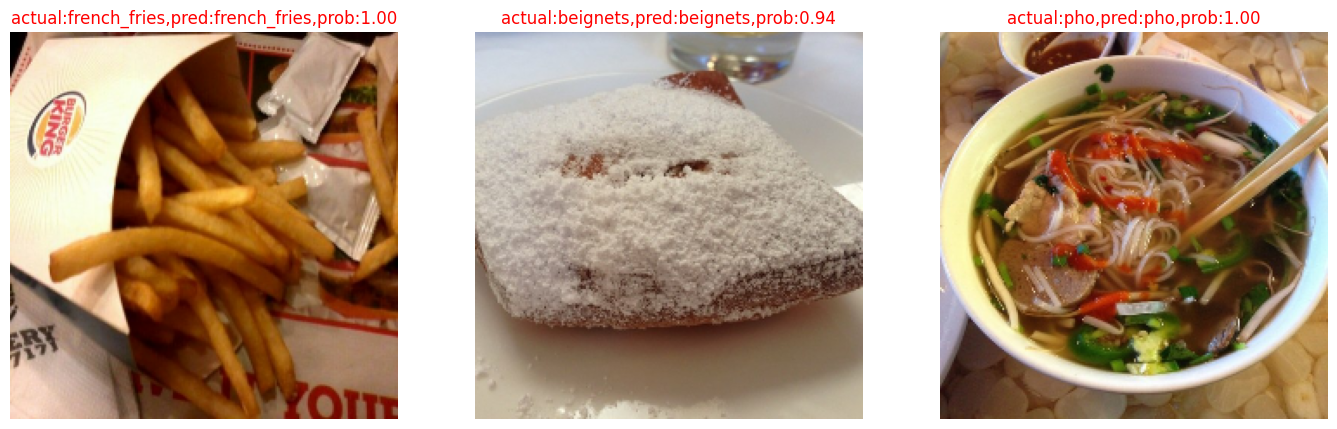

In [ ]:
# Make preds on a series of random images.
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  # choose a random image(s) from a random class(es)
  class_name = random.choice(class_names)
  filename=random.choice(os.listdir(test_dir+"/"+class_name))
  filepath=test_dir + class_name + "/" + filename
  # print(ffilepath)

  # load the image and make predictions
  img=load_and_prep_image(filepath,scale=False)
  #print(img.shape)
  img_expanded=tf.expand_dims(img,axis=0)
  #print(img_expanded.shape)
  pred_prob=model.predict(img_expanded) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probability index
  print(pred_prob)
  print(pred_class)

  # Plot the image(s)
  plt.subplot(1,3,i+1)
  #print(img)
  plt.imshow(img/255.)
  if class_names == pred_class: # if predicted class matches truth class, make text color green
    title_color= "g"
  else:
    title_color= "r"
  plt.title(f"actual:{class_name},pred:{pred_class},prob:{pred_prob.max():.2f}",c=title_color)
  plt.axis(False);

## Finding the most wrong predictions
To find out where our model is most wrong,let's write some code to find out the following:
1. Get all of the image file in the test dataset using [list_files()](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) method.
2. Create a pandas DataFrame of the image filepaths,ground truth labels,predictted classes( from our model),max prediction probabilities,prediction class names,ground truth  names.
3. Use our DataFrame to find all the wrong predictions(where the ground truth label doesn't match the prediction).
4.Sort the DataFrame based on wrong predictions(have the highest predictions probability predictions at the top).
5. Visualize the images with the highest predictions probabilities but have the wrong prediction.

In [ ]:
# 1. Get all of the image file paths in the test dataset.
filepaths = []
for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg",shuffle=False):

  filepaths.append(filepath.numpy())

filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2 . Create a DataFrame of Different paramaters for each of our test images.
import pandas as pd
pred_df = pd.DataFrame({"img_path":filepaths,
                        "y_true":y_labels,
                        "y_pred":pred_classes,
                        "pred_conf":preds_probs.max(axis=1),# get the maximimum prediction probability value
                        "y_tru_classname":[class_names[i] for i in y_labels],
                        "y_pred_classnames":[class_names[i] for i in pred_classes]})
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_tru_classname     y_pred_classnames  
0       0.847418       apple_pie                 gyoza  
1       0.964017       apple_pie             apple_pie  
2       0.959259       apple_pie             apple_pie  
3       0.658607       apple_pie  pulled_pork_sandwich  
4       0.367901       apple_pie             prime_rib  
...          ...             ...                   ...  
25245   0.972823         waffles               waffles  
25246   0.878028         waffles          cheese_plate  
25247   0.537899         waffles               waffles  
25248   0.501949         waffles  strawberry_shortcake  
25249   0.690629         waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in our dataframe which predictions are wrong
pred_df["pred_correct"]=pred_df["y_true"]== pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_tru_classname     y_pred_classnames  pred_correct  
0   0.847418       apple_pie                 gyoza         False  
1   0.964017       apple_pie             apple_pie          True  
2   0.959259       apple_pie             apple_pie          True  
3   0.658607       apple_pie  pulled_pork_sandwich         False  
4   0.367901       apple_pie             prime_rib         False

In [ ]:
# 4. Sorrt our dataframe to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"]==False].sort_values("pred_conf",ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf        y_tru_classname      y_pred_classnames  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

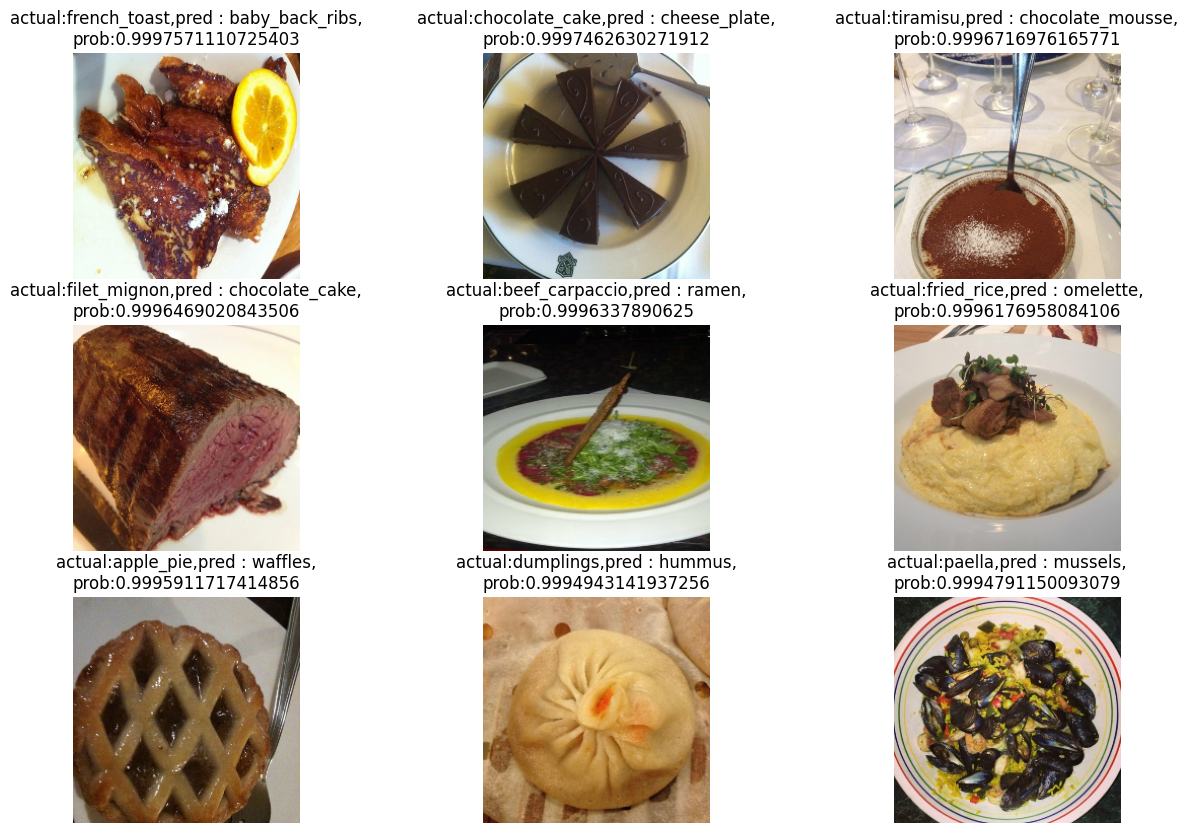

In [ ]:
# 5. Visualize the etst data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 20
plt.figure(figsize=(15,10))
for i,row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img = load_and_prep_image(row[1],scale=False)
  _,_,_,_,pred_prob,y_true_classnames,y_pred_classnames,_ = row # only interested in a afew parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual:{y_true_classnames},pred : {y_pred_classnames},\nprob:{pred_prob}")
  plt.axis(False)

## Test out the big dog model on our own custom images

In [ ]:
# Get custom images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip

--2023-09-10 08:04:50--  https://storage.googleapis.com/ztm_tf_course/food_vision/custom_food_images.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.118.207, 74.125.200.207, 74.125.130.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.118.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13192985 (13M) [application/zip]
Saving to: ‘custom_food_images.zip’

custom_food_images. 100%[===================>]  12.58M  7.62MB/s    in 1.7s    

2023-09-10 08:04:52 (7.62 MB/s) - ‘custom_food_images.zip’ saved [13192985/13192985]



In [ ]:
unzip_data("custom_food_images.zip")

In [ ]:
# Get custom food images file path
custom_food_images = ["custom_food_images/"+ img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/sushi.jpeg',
 'custom_food_images/chicken_wings.jpeg',
 'custom_food_images/steak.jpeg',
 'custom_food_images/hamburger.jpeg',
 'custom_food_images/pizza-dad.jpeg',
 'custom_food_images/ramen.jpeg']

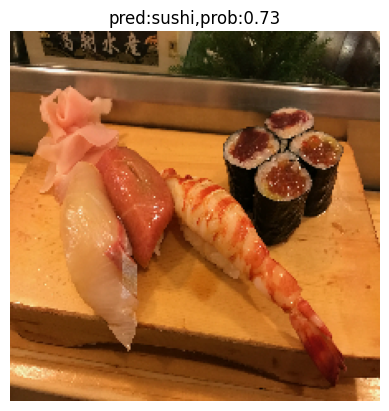

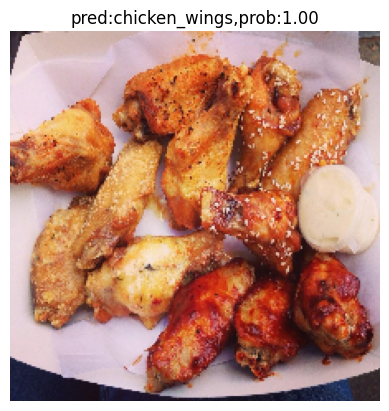

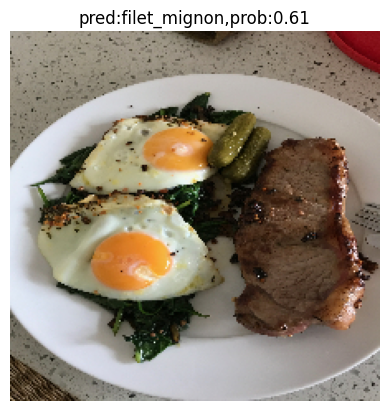

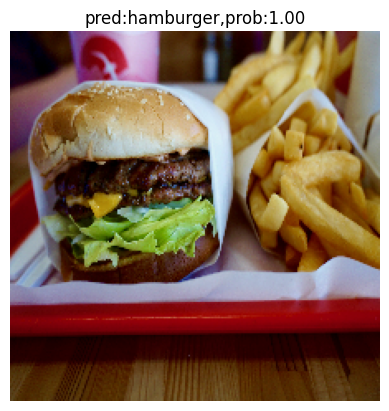

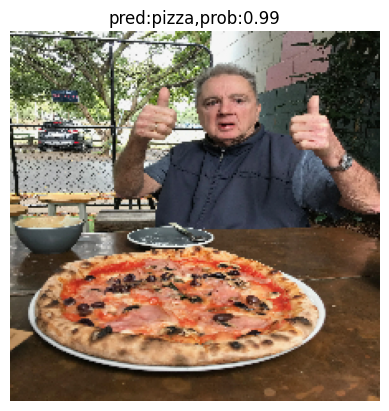

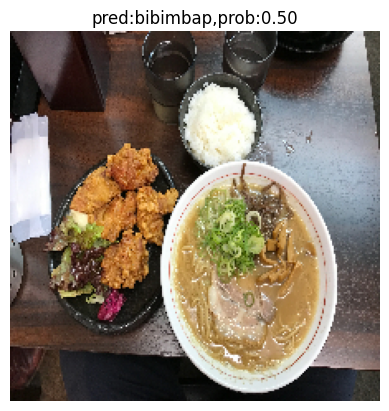

In [ ]:
# make  predictions on and plot custom food images
for img in custom_food_images:
  img = load_and_prep_image(img,scale=False) # don't need to dscale for our EfficientNetB0 model
  pred_prob = model.predict(tf.expand_dims(img,axis=0)) # make predictions on imsage with shape[1,224,224,3]( same shape as model wa strained on )
  pred_class= class_names[pred_prob.argmax()]# get the index with prediction probability
  # plot the appropriate information
  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred:{pred_class},prob:{pred_prob.max():.2f}")
  plt.axis(False)

